In [1]:
using Distributions, Plots, StatsPlots, Random, StatsBase
theme(:ggplot2)

Let $X$ by the predator population and $Y$ by the prey population. Then the following four events may happen in time:

1. A predator may be born with rate $\theta_1 XY$, increasing $X$ by $1$.
2. A predator may die with rate $\theta_2 X$, decreasing $X$ by $1$.
3. A prey may be born with rate $\theta_3 Y$, increasing $Y$ by $1$.
4. A prey may die with rate $\theta_4 XY$, decreasing $Y$ by $1$.

One way of simulating the evolutions of the predator and prey populations is through the Gillespie's algorithm. The algorithm procees as follows

1. The time to the next event is generated from an Exponential distribution with rate $\theta_1XY+\theta_2X+\theta_3Y+\theta_4XY$
2. Select one event from (1)-(4) and perform the event
3. GOTO Step 1

In [40]:
function SimLVModel(θ,TerminalTime;x0=5,y0=10,dt=1.0)
    xvec = [x0]
    yvec = [y0]
    timevec = [0.0]
    nlat = 0 
    while true
        # Obtain the rate at which the next event occurs
        rate_vec = [θ[1]*xvec[end]*yvec[end], θ[2]*xvec[end], θ[3]*yvec[end], θ[4]*xvec[end]*yvec[end]]
        # Simulate waiting time to the next event
        waiting_time = rand(Exponential(1/sum(rate_vec)))
        nlat += 1
        push!(timevec,timevec[end]+waiting_time) # Get the next event time
        if timevec[end] > TerminalTime # If the next event time exceeds the Terminal Time, STOP. 
            break
        end
        event_index = findfirst(rand() .<= cumsum(rate_vec)/sum(rate_vec))
        #event_index = sample(1:4,Weights(rate_vec)) # Sample and simulate the next event
        nlat += 1
        if event_index == 1
            push!(xvec,xvec[end]+1)
            push!(yvec,yvec[end])
        elseif event_index == 2
            push!(xvec,xvec[end]-1)
            push!(yvec,yvec[end])
        elseif event_index == 3
            push!(xvec,xvec[end])
            push!(yvec,yvec[end]+1)
        else
            push!(xvec,xvec[end])
            push!(yvec,yvec[end]-1)
        end
    end
    obstime = collect(dt:dt:TerminalTime)
    obsx = zeros(length(obstime))
    obsy = zeros(length(obstime))
    for i = 1:length(obstime)
        ind = findlast(timevec .< obstime[i])
        obsx[i] = xvec[ind]
        obsy[i] = yvec[ind]
    end
    return (x=xvec[2:end],y=yvec[2:end],t=timevec[2:end-1],obsx=obsx,obsy=obsy,obstime=obstime,nlat=nlat)
end



SimLVModel (generic function with 1 method)

657


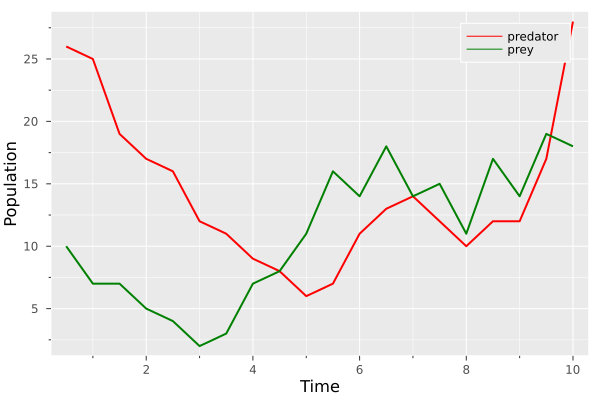

In [99]:
Random.seed!(12345)
θ = [0.05,0.5,1.0,0.05]
data = SimLVModel(θ,10,x0=20,y0=20,dt=0.5)
println(data.nlat)
plot(data.obstime,data.obsx,label="predator",xlabel="Time",ylabel="Population",color=:red,linewidth=2.0)
plot!(data.obstime,data.obsy,label="prey",color=:green,linewidth=2.0)


In the simulator, latent variables were used to generate the random waiting times and the corresponding events to be simulated. Since there is a fixed terminal time, the number of events occurred within the time interval is therefore random. We try to investigate the distribution of the number of latents used in the model by using an Monte Carlo estimation. 

In [118]:
nsamp = 10000
NlatVec = zeros(nsamp)
@time Threads.@threads for n = 1:nsamp
    data = SimLVModel(θ,10,x0=20,y0=20)
    NlatVec[n] = data.nlat
end
#histogram(NlatVec)

  0.270168 seconds (17.87 M allocations: 1.833 GiB, 56.07% gc time, 4.56% compilation time)


In [121]:
nsamp = 10000
NlatVec = zeros(nsamp)
@time for n = 1:nsamp
    data = SimLVModel(θ,10,x0=20,y0=20)
    NlatVec[n] = data.nlat
end

  0.701537 seconds (17.79 M allocations: 1.826 GiB, 20.52% gc time)


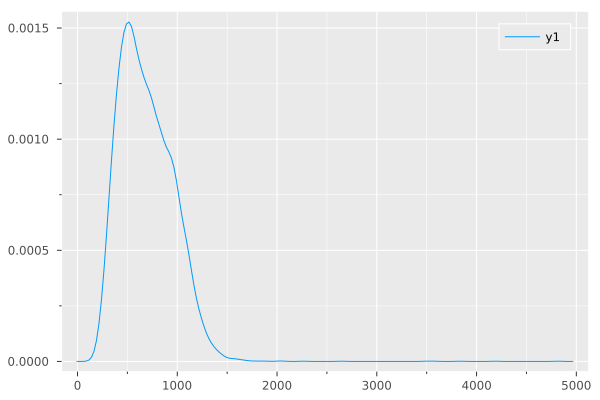

In [122]:
density(NlatVec)